In [2]:
import numpy as np
import math_tools
import matplotlib.pyplot as plt

## Spatial derivatives as linear operators

The $\nabla$ operator computes spatial gradients in a first-order forward finite-differences scheme with Neumann boundary conditions (the gradient at the boundary is $0$). See also the lecture slides, in the assignment you should use `spnabla_hp`, which is a different discretization, but is also discussed in the lecture. It is implemented as a matrix, such that $\nabla u_{\text{flat}}$ contains horizontal and vertical spatial derivatives, vertically stacked ontop of each other, where $u_{\text{flat}}$ is an image flattened in lexicographic order.

In the following cell, we decompose the $\nabla$-matrix (for a $3 \times 3$) into the parts corresponding to the spatial derivatives in the first and second principal directions (horizontal and vertical, denoted $\nabla_x$ and $\nabla_y$ respectively).

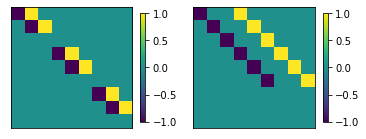

In [3]:
# Construct nabla operator for a 3 by 3 image
nabla = math_tools.spnabla(3, 3).todense()
# The first nine rows contain the matrix for x-derivatives,
# the last nine rows contain the matrix for y-derivatives.
nabla_x, nabla_y = nabla[:9], nabla[9:]

fig, ax = plt.subplots(1, 2)
ax[0].set_xticks([])
ax[0].set_yticks([])
x = ax[0].imshow(nabla_x)
fig.colorbar(x, shrink=0.5, ax=ax[0])
ax[1].set_xticks([])
ax[1].set_yticks([])
y = ax[1].imshow(nabla_y)
fig.colorbar(y, shrink=0.5, ax=ax[1])
plt.show()

Consider the image $u = \begin{bmatrix} 0, 1, 2 \\ 4, 6, 8 \\ 11, 14, 17 \end{bmatrix}$. Let's denote with $u_x$ the image containing the horizontal gradients of $u$, assuming the discretization discussed above (first-order forward finite differences with Neumann boundary conditions). By inspection, we expect $u_x = \begin{bmatrix} 1, 1, 0 \\ 2, 2, 0 \\ 3, 3, 0 \end{bmatrix}$ where the zeros are due to the Neumann boundary conditions. Let's check this:

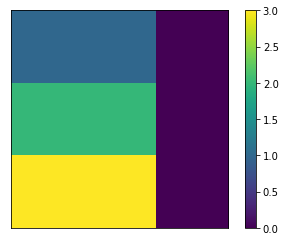

In [4]:
u = np.array([
    [0., 1., 2.],
    [4., 6., 8.],
    [11., 14., 17.],
])
u_flat = u.ravel()

u_x = (nabla_x @ u_flat).reshape(3, 3)

fig, ax = plt.subplots(1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax_ux = ax.imshow(u_x)
fig.colorbar(ax_ux, ax=ax)

Similarly, we expect $u_y= \begin{bmatrix} 4, 5, 6 \\ 7, 8, 9 \\ 0, 0, 0 \end{bmatrix}$, where again the zeros are due to the boundary conditions:

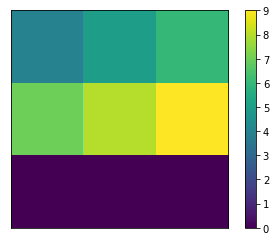

In [5]:
u_y = (nabla_y @ u_flat).reshape(3, 3)

fig, ax = plt.subplots(1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax_uy = ax.imshow(u_y)
fig.colorbar(ax_uy, ax=ax)

Let's consider the upper left pixel in $u_x$ in more detail. It is given by $(u_x)_0 = (\nabla_x u_{\text{flat}})_0 = \langle (\nabla_x)_0, u_\text{flat} \rangle$, where the subscript indicate "indexing" (either for a vector or a matrix), and $\langle \,\cdot\,, \,\cdot\, \rangle$ denotes the inner product. In other words, we can compute the upper left pixel in $u_x$ by the inner product of the flattened image $u_\text{flat}$ with some coefficient vector, $(\nabla_x)_0$. This is also true for the $i$-th pixel. Let's visualize this as images:

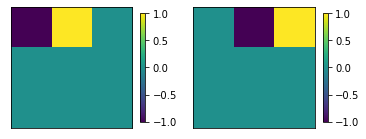

In [6]:
# Coefficient vector (viewed as image) for (u_x)_0
fig, ax = plt.subplots(1, 2)
ax[0].set_xticks([])
ax[0].set_yticks([])
x0 = ax[0].imshow(nabla_x[0].reshape(3,3))
fig.colorbar(x, shrink=0.5, ax=ax[0])
# Coefficient vector (viewed as image) for (u_x)_1
ax[1].set_xticks([])
ax[1].set_yticks([])
x1 = ax[1].imshow(nabla_x[1].reshape(3,3))
fig.colorbar(y, shrink=0.5, ax=ax[1])
plt.show()

This is just a convolution (or, more precicely, a correlation) with the kernel $[0, -1, 1]$ (the zero is added to make clear which pixel is the center). The same holds for $u_y$ with the kernel $[0, -1, 1]^\top$:

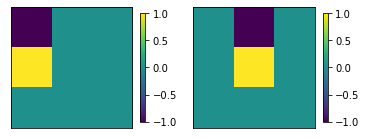

In [7]:
# Coefficient vector (viewed as image) for (u_y)_0
fig, ax = plt.subplots(1, 2)
ax[0].set_xticks([])
ax[0].set_yticks([])
y0 = ax[0].imshow(nabla_y[0].reshape(3,3))
fig.colorbar(x, shrink=0.5, ax=ax[0])
# Coefficient vector (viewed as image) for (u_y)_1
ax[1].set_xticks([])
ax[1].set_yticks([])
y1 = ax[1].imshow(nabla_y[1].reshape(3,3))
fig.colorbar(y, shrink=0.5, ax=ax[1])
plt.show()

The following cell is a complete example, showing the equivalence between the matrix formulation and the convolutions. We use the `scipy.signal.correlate2d` function instead of `scipy.signal.convolve2d`, since (mathematically) convolutions would require to rotate the filter by 90 degrees.

Text(0.5, 1.0, 'u')

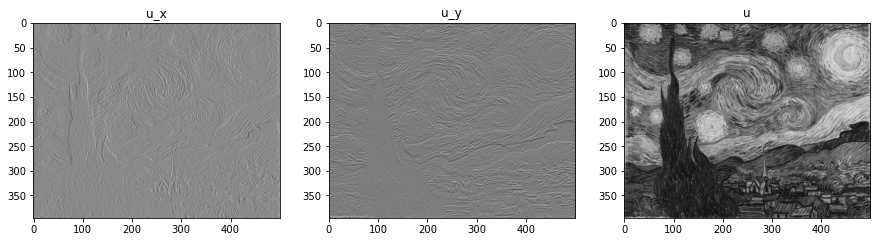

In [8]:
import scipy.signal as ss
import imageio

im = imageio.imread("./starry_night.png") / 255.
# Construct nabla operator for this image shape
nabla = math_tools.spnabla(*im.shape)
# Apply to flattened image and immediately reshape such that grad[0] contains u_x and grad[1] contains u_y (as images)
grad = (nabla @ im.ravel()).reshape(2, *im.shape)
kx = np.array([
    [0., -1, 1],
])
ky = np.array([
    [0.,],
    [-1,],
    [1,],
])
grad_ss = (
    ss.correlate2d(im, kx, mode='same', boundary='symm'),
    ss.correlate2d(im, ky, mode='same', boundary='symm'),
)

assert np.allclose(grad[0], grad_ss[0]) and np.allclose(grad[1], grad_ss[1])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(grad[0], cmap='gray')
ax[0].set_title('u_x')
ax[1].imshow(grad[1], cmap='gray')
ax[1].set_title('u_y')
ax[2].imshow(im, cmap='gray')
ax[2].set_title('u')